### Import Library

In [ ]:
import itertools
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import resnet
import pandas as pd

In [ ]:
# Directory to dataset in drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/Feri/dataset_aug_new_811.zip'

Archive:  /content/gdrive/MyDrive/Feri/dataset_aug_new_811.zip
   creating: dataset_aug_new_811/
   creating: dataset_aug_new_811/test/
   creating: dataset_aug_new_811/train/
   creating: dataset_aug_new_811/val/
   creating: dataset_aug_new_811/test/jembatan_repo/
   creating: dataset_aug_new_811/test/ancol/
   creating: dataset_aug_new_811/test/jembatan_barelang/
   creating: dataset_aug_new_811/test/simpang_lima_gumul/
   creating: dataset_aug_new_811/test/jam_gadang/
   creating: dataset_aug_new_811/test/buddha_tidur/
   creating: dataset_aug_new_811/test/monas/
   creating: dataset_aug_new_811/test/de_djawatan/
   creating: dataset_aug_new_811/test/monkasel/
   creating: dataset_aug_new_811/test/garuda_wisnu_kencana/
   creating: dataset_aug_new_811/train/jembatan_repo/
   creating: dataset_aug_new_811/train/ancol/
   creating: dataset_aug_new_811/train/jembatan_barelang/
   creating: dataset_aug_new_811/train/simpang_lima_gumul/
   creating: dataset_aug_new_811/train/jam_gadang/

### Load Image

Init variables

In [ ]:
train_data_dir = 'dataset_aug_new_811/train/'
validation_data_dir = 'dataset_aug_new_811/val/'
test_data_dir = 'dataset_aug_new_811/test/'
pairs_path = '/content/gdrive/MyDrive/Feri/csv/'

img_width = 224
img_height = 224

input_shape = (img_width, img_height, 3)
input_shape

(224, 224, 3)

In [ ]:
def read_image_dir_to_nparray(data_dir):
    x = []
    y = []
    i = 0
    
    # baca setiap folder
    for folder in os.listdir(data_dir):
        # baca tiap file
        for image_name in os.listdir(data_dir + folder):
            image = mpimg.imread(data_dir + folder + '/' + image_name)
            x.append(image)
            y.append(i)
        i += 1    
    
    # ubah kedalam numpy array
    x = np.array(x).astype('float32')    
    y = np.array(y).astype('uint8')        
    return x, y

In [ ]:
def read_image_save_location(data_dir):
    x = []
    y = []
    i = 0
    
    # baca setiap folder
    for folder in os.listdir(data_dir):
        # baca tiap file
        for image_name in os.listdir(data_dir + folder):
            x.append(data_dir + folder + '/' + image_name)
            y.append(i)
        i += 1    
    
    # ubah kedalam numpy array   
    y = np.array(y).astype('uint8')   
    return x, y

In [ ]:
x_train, y_train = read_image_dir_to_nparray(train_data_dir)
print(x_train.shape, y_train.shape)

(240, 224, 224, 3) (240,)


In [ ]:
x_val, y_val = read_image_dir_to_nparray(validation_data_dir)
print(x_val.shape, y_val.shape)

(30, 224, 224, 3) (30,)


In [ ]:
x_test, y_test = read_image_dir_to_nparray(test_data_dir)
print(x_test.shape)

(30, 224, 224, 3)


### Create Image Pairs

In [ ]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]     

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")




In [ ]:
def make_pairs_csv(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """


    pairs = []

    for idx1 in range(len(x)):
        data = x[idx1].split(':')
        x1 = mpimg.imread(data[0])
        x2 = mpimg.imread(data[1])

        pairs += [[x1, x2]]
    return np.array(pairs), np.array(y).astype("float32")


In [ ]:
# def create_pairs_csv(x, y):
#     num_classes = max(y) + 1
#     digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
#     pairs = []
#     labels = []

#     for idx1 in range(len(x)):
#         # add a matching example
#         x1 = x[idx1]
#         label1 = y[idx1]
#         idx2 = random.choice(digit_indices[label1])
#         x2 = x[idx2]

#         pairs += [x1+":"+x2]
#         labels += [1]

#         # add a non-matching example
#         label2 = random.randint(0, num_classes - 1)
#         while label2 == label1:
#             label2 = random.randint(0, num_classes - 1)

#         idx2 = random.choice(digit_indices[label2])
#         x2 = x[idx2]     

#         pairs += [x1+":"+x2]
#         labels += [0]
#     return np.array(pairs), np.array(labels).astype("float32")

# x_train_location, y_train_location = read_image_save_location(train_data_dir)
# x_val_location, y_val_location = read_image_save_location(validation_data_dir)
# x_test_location, y_test_location = read_image_save_location(test_data_dir)

# pairs_train_location, labels_train_location = create_pairs_csv(x_train_location, y_train_location)
# pairs_val_location, labels_val_location = create_pairs_csv(x_val_location, y_val_location)
# pairs_test_location, labels_test_location = create_pairs_csv(x_test_location, y_test_location)
# print(pairs_test_location)
# dict_train_pairs = {'pairs': pairs_train_location, 'labels': labels_train_location}
# dict_test_pairs = {'pairs': pairs_test_location, 'labels': labels_test_location}
# dict_val_pairs = {'pairs': pairs_val_location, 'labels': labels_val_location}

# df_train = pd.DataFrame(dict_train_pairs)
# df_test = pd.DataFrame(dict_test_pairs)
# df_val = pd.DataFrame(dict_val_pairs)

# if os.path.exists(os.path.join(pairs_path)) == False:
#   os.makedirs(os.path.join(pairs_path))

# df_train.to_csv(pairs_path+'pairs_train.csv', index=False)
# df_test.to_csv(pairs_path+'pairs_test.csv', index=False)
# df_val.to_csv(pairs_path+'pairs_val.csv', index=False)
# print(pairs_path)

In [ ]:
#read csv
df_pairs_train = pd.read_csv(pairs_path+'pairs_train.csv')
df_pairs_test = pd.read_csv(pairs_path+'pairs_test.csv')
df_pairs_val = pd.read_csv(pairs_path+'pairs_val.csv')

# make train pairs
pairs_train, labels_train = make_pairs_csv(df_pairs_train['pairs'].values, df_pairs_train['labels'].values)

# make validation pairs
pairs_val, labels_val = make_pairs_csv(df_pairs_val['pairs'].values, df_pairs_val['labels'].values)

# make test pairs
pairs_test, labels_test = make_pairs_csv(df_pairs_test['pairs'].values, df_pairs_test['labels'].values)

In [ ]:
# # make train pairs
# pairs_train, labels_train = make_pairs(x_train, y_train)

# # make validation pairs
# pairs_val, labels_val = make_pairs(x_val, y_val)

# # make test pairs
# pairs_test, labels_test = make_pairs(x_test, y_test)

In [ ]:
pairs_train.shape, labels_train.shape

((480, 2, 224, 224, 3), (480,))

**Split every pairs**

In [ ]:
x_train_1 = pairs_train[:, 0]
x_train_2 = pairs_train[:, 1]
x_train_1.shape

(480, 224, 224, 3)

In [ ]:
x_val_1 = pairs_val[:, 0]
x_val_2 = pairs_val[:, 1]
x_val_1.shape

(60, 224, 224, 3)

In [ ]:
x_test_1 = pairs_test[:, 0]
x_test_2 = pairs_test[:, 1]
x_test_1.shape

(60, 224, 224, 3)

## Visualize pairs and their labels

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("Actual: {} | Predicted: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

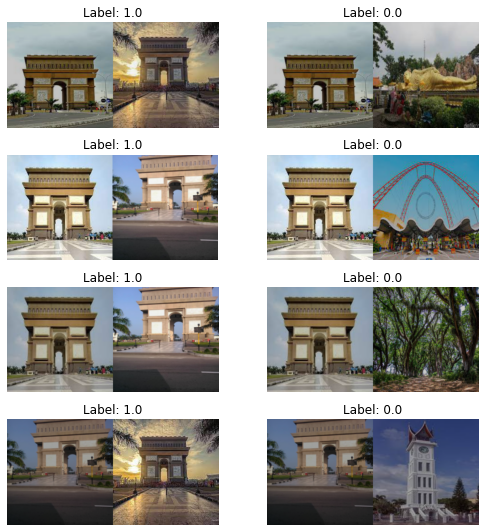

In [ ]:
visualize(pairs_train[0:50], labels_train[50:100], to_show=8, num_col=2)

In [ ]:
# visualize(pairs_val[0:20], labels_val[20:50], to_show=8, num_col=2)

## Define the model

There are be two input layers, each leading to its own network, which
produces embeddings. A `Lambda` layer then merges them using an
[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) and the
merged output is fed to the final network.

Available Pre Trained Model

https://keras.io/api/applications/#usage-examples-for-image-classification-models

This model using Fine Tuned Mobile net

https://deeplizard.com/learn/video/Zrt76AIbeh4

In [ ]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [ ]:
# import tensorflow_hub as hub
# mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
# mobile_net_layers = hub.KerasLayer(mobilenet_v2, input_shape=(224,224,3))
# mobile_net_layers.trainable = False

# mobile = tf.keras.applications.mobilenet.MobileNet()
# mobile.summary()


In [ ]:
input = keras.layers.Input((224, 224, 3))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (2, 2), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(4, (2, 2), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x) 
x = layers.Conv2D(4, (2, 2), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x) 
# x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
# x = layers.AveragePooling2D(pool_size=(2, 2))(x) 
# x = layers.Conv2D(128, (5, 5), activation="tanh")(x)
# x = layers.AveragePooling2D(pool_size=(2, 2))(x) 
# x = keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
# x = keras.layers.Dropout(0.8)(x) 
# x = keras.layers.Conv2D(32, (5, 5), activation="tanh")(x)
# x = keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
# x = keras.layers.Dropout(0.5)(x) 
# x = keras.layers.Conv2D(64, (5, 5), activation="tanh")(x)
# x = keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
# x = keras.layers.Dropout(0.5)(x) 
# x = keras.layers.Conv2D(64, (7, 7), activation="tanh")(x)
# x = keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
# x = keras.layers.Dropout(0.5)(x) 
# x = keras.layers.Conv2D(128, (7, 7), activation="tanh")(x)
# x = keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
x = keras.layers.Dropout(0.2)(x) 

x = keras.layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="tanh")(x) #10 num class
embedding_network = keras.Model(input, x)


input_1 = layers.Input((224, 224, 3))
input_2 = layers.Input((224, 224, 3))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
# x = mobile.layers[-6].output
# x
# output = Dense(units=10, activation='softmax')(x)
# model = Model(inputs=mobile.input, outputs=output)
# for layer in model.layers[:-23]:
#     layer.trainable = False

# input_1 = layers.Input((224, 224, 3))
# input_2 = layers.Input((224, 224, 3))

# # As mentioned above, Siamese Network share weights between
# # tower networks (sister networks). To allow this, we will use
# # same embedding network for both tower networks.
# tower_1 = model(input_1)
# tower_2 = model(input_2)

# merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
# normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
# output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
# siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

## Define the constrastive Loss

In [ ]:
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

## Compile the model with the contrastive loss

**Setup Hyperparameter**

In [ ]:
epochs = 100 #Change 50 100 200
batch_size = 16 #
margin = 1  # Margin for constrastive loss.

In [ ]:
from tensorflow.keras import optimizers
# siamese.compile(loss=loss(margin=margin), optimizer=optimizers.Adam(lr = 0.00006), metrics=["accuracy"]) #optimazer
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
# siamese.compile(loss=loss(margin=margin), optimizer=optimizers.Adam(lr = 1e-5), metrics=["accuracy"]) #optimazer
# siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 10)           41034       ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

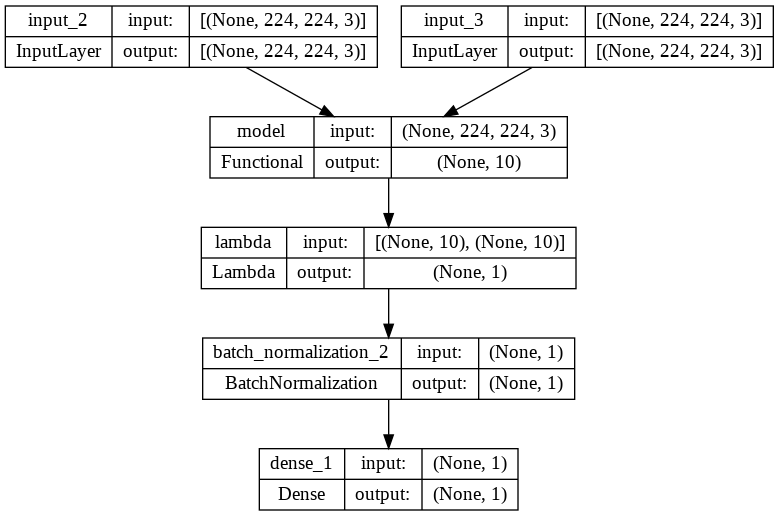

In [ ]:
dot_img_file = 'siamese_model.png'
tf.keras.utils.plot_model(siamese, to_file=dot_img_file, show_shapes=True)

In [ ]:
!pip install wandb
import wandb
from wandb.keras import WandbCallback

wandb.init(project="siamese", entity="feriafrianto")
wandb.config = {
  "epochs": 100,
  "batch_size": 16
}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Train the model

In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[WandbCallback()],
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
29/30 [============================>.] - ETA: 0s - loss: 0.1858 - accuracy: 0.7478

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 14s 119ms/step - loss: 0.1847 - accuracy: 0.7479 - val_loss: 0.1762 - val_accuracy: 0.8000
Epoch 2/100
29/30 [============================>.] - ETA: 0s - loss: 0.1637 - accuracy: 0.8168

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 94ms/step - loss: 0.1629 - accuracy: 0.8188 - val_loss: 0.1661 - val_accuracy: 0.7500
Epoch 3/100
28/30 [===========================>..] - ETA: 0s - loss: 0.1481 - accuracy: 0.8482

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 102ms/step - loss: 0.1487 - accuracy: 0.8458 - val_loss: 0.1262 - val_accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.8875

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 94ms/step - loss: 0.1318 - accuracy: 0.8875 - val_loss: 0.1021 - val_accuracy: 0.8667
Epoch 5/100
30/30 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9021

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 105ms/step - loss: 0.1229 - accuracy: 0.9021 - val_loss: 0.0880 - val_accuracy: 0.9167
Epoch 6/100
30/30 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.8938

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 95ms/step - loss: 0.1222 - accuracy: 0.8938 - val_loss: 0.0792 - val_accuracy: 0.8667
Epoch 7/100
30/30 [==============================] - 1s 25ms/step - loss: 0.1133 - accuracy: 0.9021 - val_loss: 0.0934 - val_accuracy: 0.8500
Epoch 8/100
28/30 [===========================>..] - ETA: 0s - loss: 0.1045 - accuracy: 0.9196

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 91ms/step - loss: 0.1055 - accuracy: 0.9187 - val_loss: 0.0696 - val_accuracy: 0.9500
Epoch 9/100
30/30 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.9083

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 104ms/step - loss: 0.1081 - accuracy: 0.9083 - val_loss: 0.0643 - val_accuracy: 0.9333
Epoch 10/100
30/30 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9583

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 95ms/step - loss: 0.0854 - accuracy: 0.9583 - val_loss: 0.0501 - val_accuracy: 0.9667
Epoch 11/100
30/30 [==============================] - 1s 25ms/step - loss: 0.0794 - accuracy: 0.9521 - val_loss: 0.0519 - val_accuracy: 0.9667
Epoch 12/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0768 - accuracy: 0.9438 - val_loss: 0.0514 - val_accuracy: 0.9833
Epoch 13/100
28/30 [===========================>..] - ETA: 0s - loss: 0.0645 - accuracy: 0.9732

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 98ms/step - loss: 0.0638 - accuracy: 0.9729 - val_loss: 0.0493 - val_accuracy: 0.9667
Epoch 14/100
30/30 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9812

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.1s


30/30 [==============================] - 3s 100ms/step - loss: 0.0637 - accuracy: 0.9812 - val_loss: 0.0329 - val_accuracy: 0.9667
Epoch 15/100
29/30 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9698

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 106ms/step - loss: 0.0622 - accuracy: 0.9688 - val_loss: 0.0305 - val_accuracy: 0.9500
Epoch 16/100
28/30 [===========================>..] - ETA: 0s - loss: 0.0530 - accuracy: 0.9732

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 104ms/step - loss: 0.0520 - accuracy: 0.9750 - val_loss: 0.0230 - val_accuracy: 1.0000
Epoch 17/100
30/30 [==============================] - 1s 24ms/step - loss: 0.0534 - accuracy: 0.9708 - val_loss: 0.0268 - val_accuracy: 1.0000
Epoch 18/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0473 - accuracy: 0.9729 - val_loss: 0.0334 - val_accuracy: 0.9667
Epoch 19/100
28/30 [===========================>..] - ETA: 0s - loss: 0.0415 - accuracy: 0.9866

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 91ms/step - loss: 0.0409 - accuracy: 0.9875 - val_loss: 0.0197 - val_accuracy: 1.0000
Epoch 20/100
30/30 [==============================] - 1s 26ms/step - loss: 0.0411 - accuracy: 0.9854 - val_loss: 0.0204 - val_accuracy: 1.0000
Epoch 21/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0446 - accuracy: 0.9750 - val_loss: 0.0222 - val_accuracy: 1.0000
Epoch 22/100
28/30 [===========================>..] - ETA: 0s - loss: 0.0402 - accuracy: 0.9754

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 102ms/step - loss: 0.0398 - accuracy: 0.9750 - val_loss: 0.0173 - val_accuracy: 1.0000
Epoch 23/100
28/30 [===========================>..] - ETA: 0s - loss: 0.0231 - accuracy: 0.9933

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 97ms/step - loss: 0.0235 - accuracy: 0.9937 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 24/100
30/30 [==============================] - 1s 24ms/step - loss: 0.0212 - accuracy: 0.9937 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 25/100
30/30 [==============================] - 1s 22ms/step - loss: 0.0252 - accuracy: 0.9937 - val_loss: 0.0149 - val_accuracy: 1.0000
Epoch 26/100
30/30 [==============================] - 1s 22ms/step - loss: 0.0335 - accuracy: 0.9729 - val_loss: 0.0144 - val_accuracy: 1.0000
Epoch 27/100
30/30 [==============================] - 1s 22ms/step - loss: 0.0199 - accuracy: 0.9937 - val_loss: 0.0119 - val_accuracy: 1.0000
Epoch 28/100
28/30 [===========================>..] - ETA: 0s - loss: 0.0279 - accuracy: 0.9777

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 92ms/step - loss: 0.0281 - accuracy: 0.9792 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 29/100
30/30 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9812

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 106ms/step - loss: 0.0209 - accuracy: 0.9812 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 30/100
29/30 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9914

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 95ms/step - loss: 0.0158 - accuracy: 0.9917 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 31/100
28/30 [===========================>..] - ETA: 0s - loss: 0.0166 - accuracy: 0.9933

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 106ms/step - loss: 0.0158 - accuracy: 0.9937 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 32/100
30/30 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9979

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 97ms/step - loss: 0.0109 - accuracy: 0.9979 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 33/100
30/30 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9875

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 96ms/step - loss: 0.0148 - accuracy: 0.9875 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 34/100
30/30 [==============================] - 1s 24ms/step - loss: 0.0125 - accuracy: 0.9896 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 35/100
28/30 [===========================>..] - ETA: 0s - loss: 0.0105 - accuracy: 0.9955

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 104ms/step - loss: 0.0102 - accuracy: 0.9958 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 36/100
30/30 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9979

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 94ms/step - loss: 0.0102 - accuracy: 0.9979 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 37/100
30/30 [==============================] - 1s 26ms/step - loss: 0.0182 - accuracy: 0.9812 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 38/100
30/30 [==============================] - 1s 22ms/step - loss: 0.0116 - accuracy: 0.9917 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 39/100
30/30 [==============================] - 1s 22ms/step - loss: 0.0203 - accuracy: 0.9771 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 40/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0065 - accuracy: 0.9979 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 41/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0082 - accuracy: 0.9958 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 42/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0074 - accuracy: 0.9937 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 43/100

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 101ms/step - loss: 0.0142 - accuracy: 0.9833 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 51/100
30/30 [==============================] - 1s 25ms/step - loss: 0.0139 - accuracy: 0.9833 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 52/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0166 - accuracy: 0.9833 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 53/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0110 - accuracy: 0.9854 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 54/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0083 - accuracy: 0.9917 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 55/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0131 - accuracy: 0.9896 - val_loss: 0.0268 - val_accuracy: 0.9667
Epoch 56/100
28/30 [===========================>..] - ETA: 0s - loss: 0.0169 - accuracy: 0.9754

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 92ms/step - loss: 0.0187 - accuracy: 0.9750 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 57/100
30/30 [==============================] - 1s 25ms/step - loss: 0.0172 - accuracy: 0.9750 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 58/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0122 - accuracy: 0.9875 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 59/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0088 - accuracy: 0.9937 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 60/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0165 - accuracy: 0.9833 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 61/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0254 - accuracy: 0.9708 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 62/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0135 - accuracy: 0.9833 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 63/100

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 91ms/step - loss: 0.0184 - accuracy: 0.9729 - val_loss: 6.5943e-04 - val_accuracy: 1.0000
Epoch 71/100
30/30 [==============================] - 1s 24ms/step - loss: 0.0172 - accuracy: 0.9771 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 72/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0063 - accuracy: 0.9979 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 73/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0134 - accuracy: 0.9854 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 74/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0094 - accuracy: 0.9896 - val_loss: 9.8461e-04 - val_accuracy: 1.0000
Epoch 75/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0173 - accuracy: 0.9812 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 76/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0129 - accuracy: 0.9750 - val_loss: 0.0109 - val_accuracy: 0.9667
Epoc

wandb: Adding directory to artifact (/content/wandb/run-20221212_014543-3b1kkt39/files/model-best)... Done. 0.0s


30/30 [==============================] - 3s 101ms/step - loss: 0.0190 - accuracy: 0.9812 - val_loss: 8.9461e-05 - val_accuracy: 1.0000
Epoch 100/100
30/30 [==============================] - 1s 24ms/step - loss: 0.0122 - accuracy: 0.9875 - val_loss: 9.4785e-04 - val_accuracy: 1.0000


## Visualize results

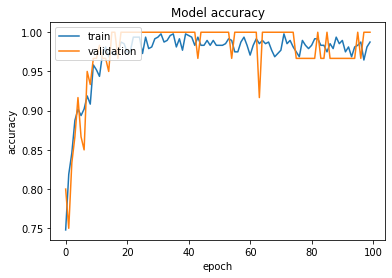

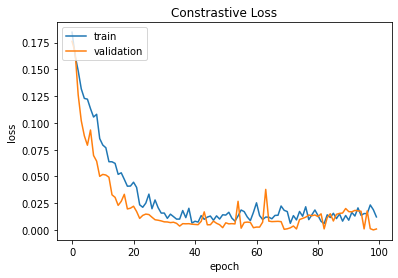

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

## Evaluate the model

In [ ]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)
print("Accuracy: %.2f%%" % (results[1]*100))
print("Loss: %.2f%%" % (results[0]*100))

2/2 [==============================] - 0s 142ms/step - loss: 0.0166 - accuracy: 0.9833
test loss, test acc: [0.016599636524915695, 0.9833333492279053]
Accuracy: 98.33%
Loss: 1.66%


## Visualize the predictions

2/2 [==============================] - 0s 14ms/step


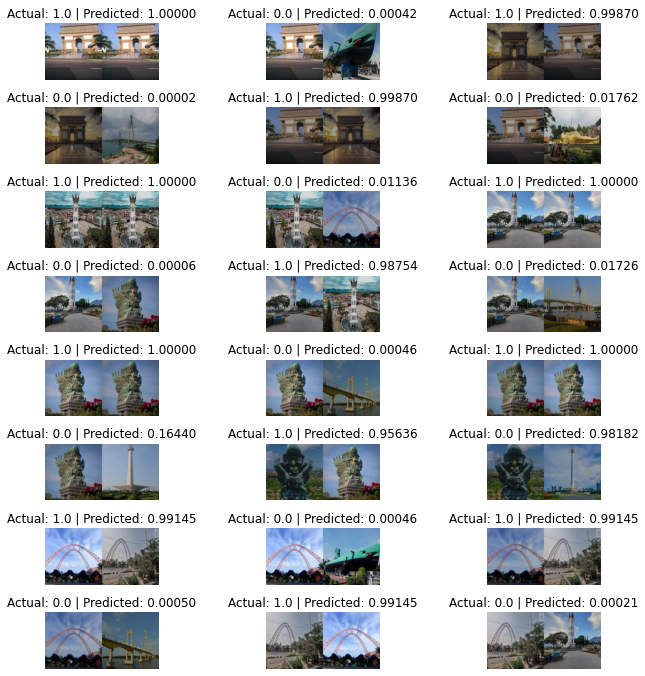

In [ ]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=24, predictions=predictions, test=True)

In [ ]:
from datetime import datetime
filename = "/content/gdrive/MyDrive/Feri/Model/model_"+ str(results[1]*100) + "%_" +datetime.now().strftime("%Y-%m-%d_%H-%M-%S")+".h5"
siamese.save_weights(filename)
print(filename)

/content/gdrive/MyDrive/Feri/Model/model_98.33333492279053%_2022-12-12_01-48-47.h5
